In [1]:
# import numpy for linear algebra and array list
import numpy as np 
# used to read csv files and create dataframes
import pandas as pd 
# to scale graphs and surpress errors in plotting 
%matplotlib inline 
# plotting library, for simple plots
import matplotlib.pyplot as plt 
 # plotting utility
import seaborn as sns
sns.set() # enabling plotting utility 
# Splitting the data into train-test values
from sklearn.model_selection import train_test_split
# standard scalar for normalizing the datasets 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# importing XGBClassifier 
from xgboost import XGBClassifier
#import naive_bayes 
from sklearn.naive_bayes import GaussianNB
# importing Logistic Regression from sklearn models 
from sklearn.linear_model import LogisticRegression
#importing Random Forest Classifier from sklearn.ensemble 
from sklearn.ensemble import RandomForestClassifier
# importing metrics for evaluation of the model 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 
# importing warnings 
import warnings as wr
wr.filterwarnings("ignore")
#import dataset
data = pd.read_csv("/content/bank-additional-full.csv", sep=';')
# Detailed information of the dataframe
data.info()
#display top 1000 rows
data.head(1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,32,entrepreneur,married,basic.6y,no,yes,no,telephone,may,wed,163,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
996,41,services,single,high.school,no,yes,yes,telephone,may,wed,345,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
997,59,housemaid,married,basic.6y,no,yes,no,telephone,may,wed,329,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
998,57,technician,married,basic.9y,no,yes,no,telephone,may,wed,68,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no


In [2]:
#viewing columns of the data set 
cols = list(data.columns)
for col in cols:
    for i in range(data.shape[0]):
        if col == "job" and data[col][i] == "unknown":
            data[col][i] = "unemployed"  #Assuming unemployed status
        if col == "marital" and data[col][i] == "unknown":
            data[col][i] = "single" #Assuming 'Single' status
        if col == "education" and data[col][i] == "unknown":
            data[col][i] = "illiterate" #Assuming uneducated status    
        if col in ["default", "housing", "loan"] and data[col][i] == "unknown":
            data[col][i] = None
        # Similarly, pdays = 999 indicates the client was not contacted and deemed not interested so can be dropped.
        if col == "pdays" and data[col][i] == 999:
            data[col][i] = None
        # poutcome can either be success or failure. Thus, nonexistant =  missing data and, can be dropped.
        if col == "poutcome" and data[col][i] == "nonexistent":
            data[col][i] = None


In [3]:
data.isna().sum()

age                   0
job                   0
marital               0
education             0
default            8597
housing             990
loan                990
contact               0
month                 0
day_of_week           0
duration              0
campaign              0
pdays             39673
previous              0
poutcome          35563
emp.var.rate          0
cons.price.idx        0
cons.conf.idx         0
euribor3m             0
nr.employed           0
y                     0
dtype: int64

In [4]:
# pdays, previous and poutcome columns can be dropped since most of the clients seem to be new.
data.drop(['pdays', 'poutcome', 'previous'], axis=1, inplace=True)
# Drop the records with missing data
data.dropna(axis=0, how='any', inplace=True)

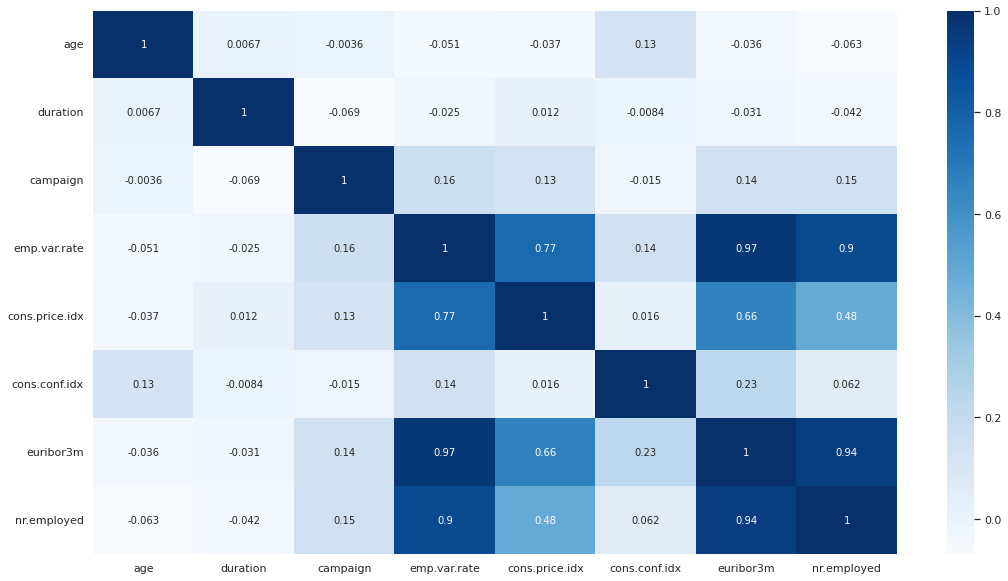

In [5]:
# Lets check for correlated data
correlated_data = data.corr()
# plot the correlation graph
plt.figure(figsize= (18,10))
#visualize and annotae the correlated data
sns.heatmap(correlated_data, cmap="Blues", annot=True)
# to show the graph
plt.show()


In [6]:

# duration also can be dropped for the purpose of predictive analysis.
data.drop(['emp.var.rate', 'euribor3m', 'nr.employed', 'duration'], axis=1, inplace=True)
# Converting categorical and binary type columns to numerical type for easy computation. 
binary_cols = ['default', 'housing', 'loan', 'y']
dummy_list = [] # initialize the empty list for dummies 
for c in binary_cols: #iterate while creating new values 
    for text in data[c].values:
        if text == 'yes':
            dummy_list.append(1)
        else:
            dummy_list.append(0)
    data[c] = dummy_list
    dummy_list = []

# generate new integer values for non integers 
job_types = {'admin.':1,'blue-collar':2,'entrepreneur':3,'housemaid':4,'management':5,'retired':6,'self-employed':7,
             'services':8,'student':9,'technician':10,'unemployed':11}
marital_status = {'divorced':1,'married':2,'single':3}
edu = {'basic.4y':1,'basic.6y':2,'basic.9y':3,'high.school':4,'illiterate':5,'professional.course':6,'university.degree':7}
contact_type = {'cellular':1,'telephone':2}
months = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
days = {'mon':1,'tue':2,'wed':3,'thu':4,'fri':5}

# copy dummy values back to the original dataset 
cpy = []
for txt in data['job'].values:
    cpy.append(job_types[txt])
data['job'] = cpy
cpy = []
for txt in data['marital'].values:
    cpy.append(marital_status[txt])
data['marital'] = cpy
cpy = []
for txt in data['education'].values:
    cpy.append(edu[txt])
data['education'] = cpy
cpy = []
for txt in data['contact'].values:
    cpy.append(contact_type[txt])
data['contact'] = cpy
cpy = []
for txt in data['month'].values:
    cpy.append(months[txt])
data['month'] = cpy
cpy = []
for txt in data['day_of_week'].values:
    cpy.append(days[txt])
data['day_of_week'] = cpy
cpy = []
#load data again
data
# y refers to the target variable, response where 0 - 1 means subscribed and 0 means not subscribed

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,cons.price.idx,cons.conf.idx,y
0,56,4,2,1,0,0,0,2,5,1,1,93.994,-36.4,0
2,37,8,2,4,0,1,0,2,5,1,1,93.994,-36.4,0
3,40,1,2,2,0,0,0,2,5,1,1,93.994,-36.4,0
4,56,8,2,4,0,0,1,2,5,1,1,93.994,-36.4,0
6,59,1,2,6,0,0,0,2,5,1,1,93.994,-36.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,6,2,6,0,1,0,1,11,5,1,94.767,-50.8,1
41184,46,2,2,6,0,0,0,1,11,5,1,94.767,-50.8,0
41185,56,6,2,7,0,1,0,1,11,5,2,94.767,-50.8,0
41186,44,10,2,6,0,0,0,1,11,5,1,94.767,-50.8,1



 Displaying results for unbalanced dataset

 ========== Displaying results for Logistic Regression ========== 

 Accuracy score for Logistic Regression is : 87.40%


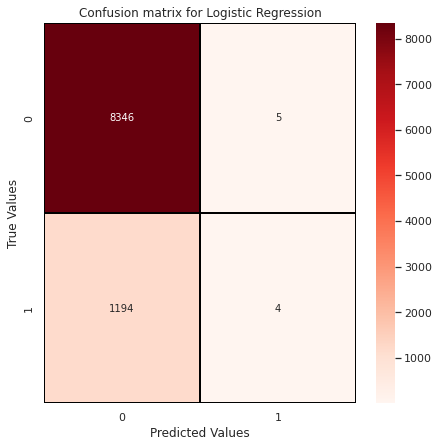

Classification Report:
                     0            1  accuracy    macro avg  weighted avg
precision     0.874843     0.444444  0.874437     0.659644      0.820846
recall        0.999401     0.003339  0.874437     0.501370      0.874437
f1-score      0.932983     0.006628  0.874437     0.469806      0.816764
support    8351.000000  1198.000000  0.874437  9549.000000   9549.000000

 ========== Displaying results for Naive Bayes ========== 

 Accuracy score for Naive Bayes is : 43.30%


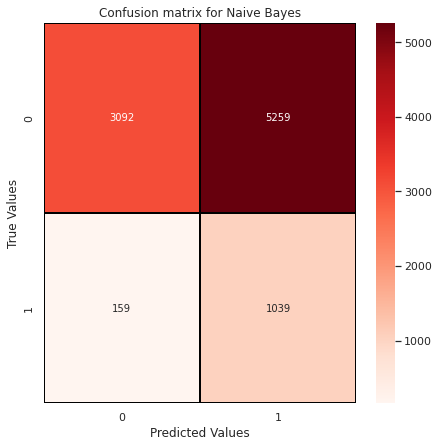

Classification Report:
                     0            1  accuracy    macro avg  weighted avg
precision     0.951092     0.164973  0.432611     0.558032      0.852467
recall        0.370255     0.867279  0.432611     0.618767      0.432611
f1-score      0.533012     0.277215  0.432611     0.405113      0.500920
support    8351.000000  1198.000000  0.432611  9549.000000   9549.000000

 ========== Displaying results for Random Forest ========== 

 Accuracy score for Random Forest is : 87.40%


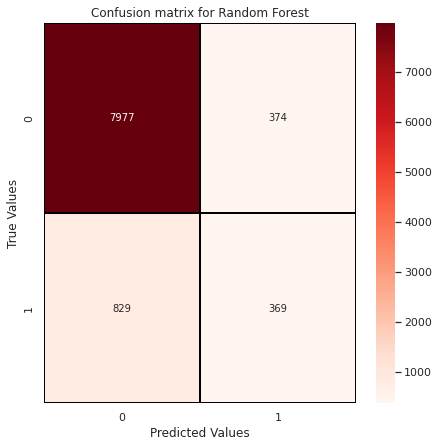

Classification Report:
                     0            1  accuracy    macro avg  weighted avg
precision     0.905860     0.496635  0.874018     0.701247      0.854519
recall        0.955215     0.308013  0.874018     0.631614      0.874018
f1-score      0.929883     0.380216  0.874018     0.655050      0.860923
support    8351.000000  1198.000000  0.874018  9549.000000   9549.000000


In [7]:
# split the data set with train_test_split function
target = data['y'] # where y is the target column 
feature_set = data.drop(['y'], axis=1) # gets other columns excluding the target column y 
# split the dataset 
X_train, X_test, Y_train, Y_test = train_test_split(feature_set,target, test_size=0.3, random_state=0)
#initialize classification algorithms 
classifiers = [('Logistic Regression', LogisticRegression()),
               ('Naive Bayes', GaussianNB()),
               ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=0, criterion='gini', bootstrap=True, oob_score=True))]

print(f"\n Displaying results for unbalanced dataset")
# iterate through the classes while fitting the model, making predictions and evaluating each classification
for name, classifier in classifiers:
    score = 0
    # fit the model 
    classifier = classifier.fit(X_train, Y_train)
    # make predictions 
    predicted_target = classifier.predict(X_test)
    # compute the  accuracy score in percentage and round to 2 decimal places
    score = accuracy_score(Y_test,predicted_target)
    print(f"\n ========== Displaying results for %s ========== "%name)
    print(f"\n Accuracy score for {name} is : {round(score, 3)* 100:.2f}%")
    #generate a confusion matrix 
    cm = confusion_matrix(Y_test, predicted_target)
    #  generate a classification report from the metricx 
    cl_report = pd.DataFrame(classification_report(Y_test, predicted_target, output_dict=True))
    fig, ax = plt.subplots(figsize=(7,7))
    # plot the confusion matrix graph using seaborn and matplotlib 
    sns.heatmap(cm, annot=True,linewidths=1.5,linecolor="#000000",fmt=".0f",ax=ax, cmap="Reds")
    plt.title("Confusion matrix for {}".format(name))
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    # display the graph 
    plt.show()
    # display the classification report 
    print(f"Classification Report:\n{cl_report}")

Counter({0: 27727, 1: 27727})

 Displaying results for balanced dataset  

 ========== Displaying results for Logistic Regression ========== 

 Accuracy score for Logistic Regression is : 70.80%


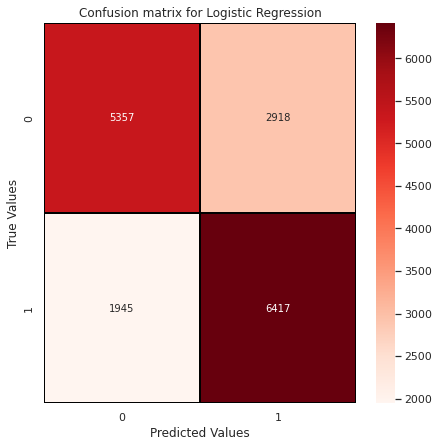

Classification Report:
                     0            1  accuracy     macro avg  weighted avg
precision     0.733635     0.687413    0.7077      0.710524      0.710403
recall        0.647372     0.767400    0.7077      0.707386      0.707700
f1-score      0.687809     0.725208    0.7077      0.706508      0.706606
support    8275.000000  8362.000000    0.7077  16637.000000  16637.000000

 ========== Displaying results for Naive Bayes ========== 

 Accuracy score for Naive Bayes is : 66.90%


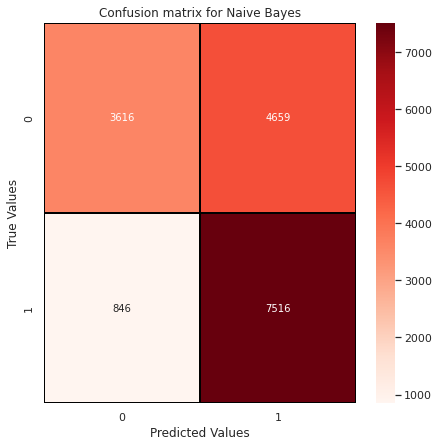

Classification Report:
                     0            1  accuracy     macro avg  weighted avg
precision     0.810399     0.617331  0.669111      0.713865      0.713360
recall        0.436979     0.898828  0.669111      0.667903      0.669111
f1-score      0.567795     0.731947  0.669111      0.649871      0.650300
support    8275.000000  8362.000000  0.669111  16637.000000  16637.000000

 ========== Displaying results for Random Forest ========== 

 Accuracy score for Random Forest is : 89.20%


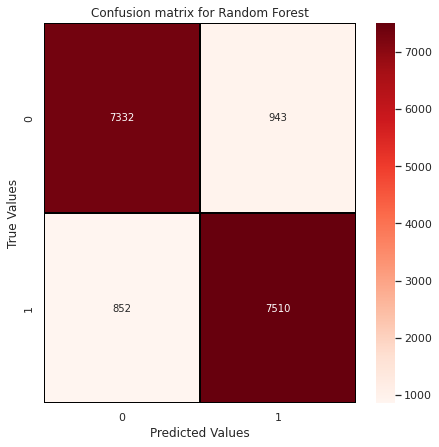

Classification Report:
                     0            1  accuracy     macro avg  weighted avg
precision     0.895894     0.888442  0.892108      0.892168      0.892149
recall        0.886042     0.898110  0.892108      0.892076      0.892108
f1-score      0.890941     0.893250  0.892108      0.892096      0.892102
support    8275.000000  8362.000000  0.892108  16637.000000  16637.000000


In [8]:
# balance the dataset and training again
# ***** ============== balancing of the dataset starts here ===== **** 
# import library Synthetic Minority Oversampling Technique(SMOTE) from imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
# fit predictor and target variable
target = data['y'] # where y is the target column 
feature_set = data.drop(['y'], axis=1) # gets other columns excluding the target column y 
# initialize (SMOTE)
smote = SMOTE()
#fit and resample to balance the dataset
feature_set, target = smote.fit_resample(feature_set, target)
# count the 1's and 0's 
counter = Counter(target)
print(counter)
data
# ***** balancing of dataset ends here ********
# split the dataset 
X_train, X_test, Y_train, Y_test = train_test_split(feature_set,target, test_size=0.3, random_state=0)
#initialize classification algoritms 
models = [('Logistic Regression', LogisticRegression()),
          ('Naive Bayes', GaussianNB()),
          ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=0, criterion='gini', bootstrap=True, oob_score=True))
          ]

print(f"\n Displaying results for balanced dataset  ")
# iterate through the classes while fitting the model, making predictions and evaluating each classification
for name, classifier in models:
    score = 0
    # fit the model 
    classifier = classifier.fit(X_train, Y_train)
    # make predictions 
    predicted_target = classifier.predict(X_test)
    # compute the  accuracy score in percentage and round to 2 decimal places
    score = accuracy_score(Y_test,predicted_target)
    print(f"\n ========== Displaying results for %s ========== "%name)
    print(f"\n Accuracy score for {name} is : {round(score, 3)* 100:.2f}%")
    #generate a confusion matrix 
    cm = confusion_matrix(Y_test, predicted_target)
    #  generate a classification report from the metricx 
    cl_report = pd.DataFrame(classification_report(Y_test, predicted_target, output_dict=True))
    fig, ax = plt.subplots(figsize=(7,7))
    # plot the confusion matrix graph using seaborn and matplotlib 
    sns.heatmap(cm, annot=True,linewidths=1.5,linecolor="#000000",fmt=".0f",ax=ax, cmap="Reds")
    plt.title("Confusion matrix for {}".format(name))
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    # display the graph 
    plt.show()
    # display the classification report 
    print(f"Classification Report:\n{cl_report}")
